## **Problem Statement**

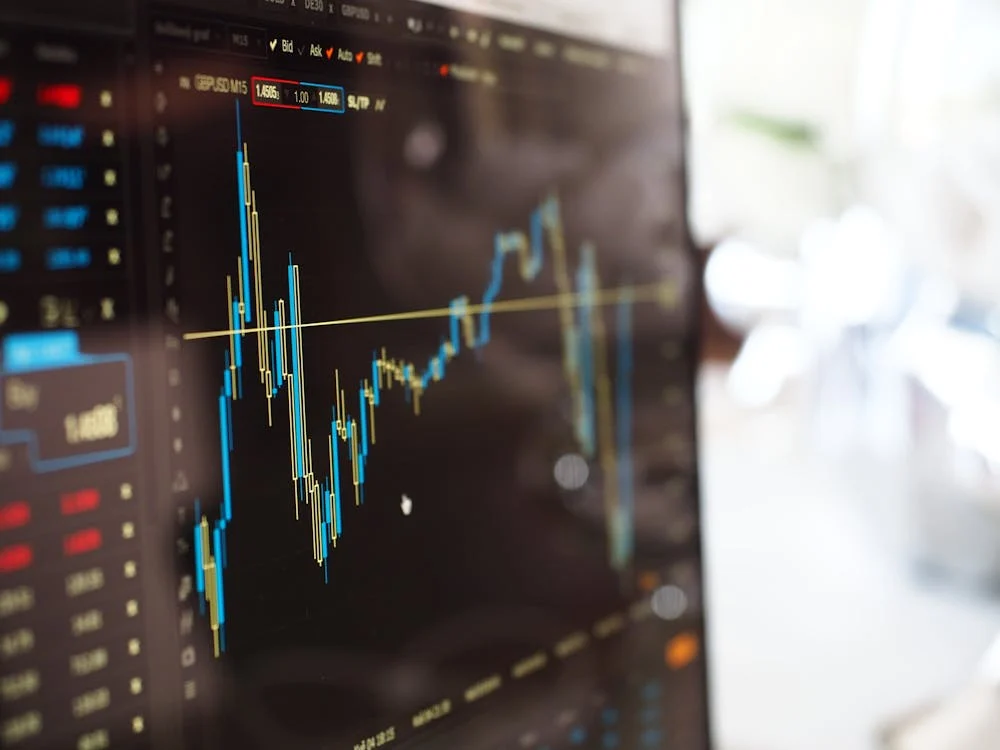

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2\
             mlflow==3.5.1

In [ ]:
!pip install --upgrade pip
!pip install numpy scikit-learn gensim sentence-transformers pandas mlflow ipywidgets

Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [2]:
# To manipulate and analyze data
import pandas as pd
import numpy as np
import gc

# To visualize data
import matplotlib.pyplot as plt
import seaborn as sns

# To used time-related functions
import time

# To build, tune, and evaluate ML models
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# To load/create word embeddings
from gensim.models import Word2Vec

# To work with transformer models
import torch
from sentence_transformers import SentenceTransformer

# Import TensorFlow and Keras for deep learning model building.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Import MLFLOW
import mlflow
import mlflow.sklearn
import mlflow.tensorflow

# To implement progress bar related functionalities
from tqdm import tqdm
tqdm.pandas()

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## Utility Functions

In [3]:
def model_performance_classification_sklearn(actual, predicted):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(actual,predicted)
    # Compute Recall
    recall = recall_score(actual,predicted,average='weighted')
    # Compute Precision
    precision = precision_score(actual,predicted,average='weighted')
    # Compute F1-score
    f1 = f1_score(actual,predicted,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

def plot_confusion_matrix(actual, predicted):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((actual, predicted)))))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

def distribution_plot_feature_target(data, predictor, target):

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    target_uniq = data[target].unique()

    axs[0, 0].set_title(f"Distribution of target={target} for target=" + str(target_uniq[0]))
    sns.histplot(
        data=data[data[target] == target_uniq[0]],
        x=predictor,
        kde=True,
        ax=axs[0, 0],
        color="teal",
        stat="density",
    )

    axs[0, 1].set_title(f"Distribution of target={target} for target=" + str(target_uniq[1]))
    sns.histplot(
        data=data[data[target] == target_uniq[1]],
        x=predictor,
        kde=True,
        ax=axs[0, 1],
        color="orange",
        stat="density",
    )

    axs[1, 0].set_title(f"Boxplot {target} target")
    sns.boxplot(data=data, x=target, y=predictor, ax=axs[1, 0], palette="gist_rainbow")

    axs[1, 1].set_title(f"Boxplot (without outliers) {target} target")
    sns.boxplot(
        data=data,
        x=target,
        y=predictor,
        ax=axs[1, 1],
        showfliers=False,
        palette="gist_rainbow",
    )


def distribution_hist(df: pd.DataFrame, feature_numeric):
    if df[feature_numeric].dtype.kind in ("i","f"):
        # Distribution plot
        sns.histplot(data=df, x=f"{feature_numeric}",palette="viridis",kde=True)
        # Add a title and show the plot
        plt.title(f"Distribution Plot for {feature_numeric}")
        plt.show()
    else:
        print(f"Error {feature_numeric} dtype needs to be numeric")

#########
# function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="viridis",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage
    plt.figure(figsize=(10,5))
    plt.show()  # show the plot

########

def correlation_heatmap(df, figsize=(14, 10), title="Correlation Heatmap"):
    df = df.select_dtypes(exclude=['category', 'object'])
    corr = df.corr()

    # Mask the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)

    # Custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Heatmap
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        vmin=-1,
        vmax=1,
        cmap=cmap,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75},
        annot_kws={"size": 10, "weight": "bold", "color": "black"}
    )

    # Titles and layout
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

def correlation_heatmap(df, figsize=(14, 10), title="Correlation Heatmap"):
    df = df.select_dtypes(exclude=['category', 'object'])
    corr = df.corr()

    # Mask the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=figsize)

    # Custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Heatmap
    sns.heatmap(
        corr,
        mask=mask,
        annot=True,
        fmt=".2f",
        vmin=-1,
        vmax=1,
        cmap=cmap,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75},
        annot_kws={"size": 10, "weight": "bold", "color": "black"}
    )

    # Titles and layout
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(actual, predicted):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((actual, predicted)))))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()


def model_performance_classification_sklearn(actual, predicted):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(actual,predicted)
    # Compute Recall
    recall = recall_score(actual,predicted,average='weighted')
    # Compute Precision
    precision = precision_score(actual,predicted,average='weighted')
    # Compute F1-score
    f1 = f1_score(actual,predicted,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

## **Loading the dataset**

In [4]:
#stocks_reviews = pd.read_csv('stock_news.csv')
#data = stocks_reviews.copy()

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Update the file path below to the correct location of your file in Google Drive
#stocks_reviews = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/UTA_Project/stock_news.csv')
#data = stocks_reviews.copy()

stocks_reviews = pd.read_csv('stock_news.csv')
data = stocks_reviews.copy()

## **Data Overview**

In [5]:
print(f"[-] Shape of the data:\nColumns: {data.shape[1]}\nRows: {data.shape[0]}")
print(f"[-] Missing values {data.isnull().sum()}")
print(f"[-] Duplicates: {data.duplicated().sum()}")

# keeping only the first occurence of duplicate values and dropping the rest
data = data.drop_duplicates(keep = 'first')

# keeping only the first occurence of duplicate values and dropping the rest
data = data.drop_duplicates(keep='first')
# reseting the index of the dataframe
data = data.reset_index(drop=True)


[-] Shape of the data:
Columns: 8
Rows: 418
[-] Missing values Date      0
News      0
Open      0
High      0
Low       0
Close     0
Volume    0
Label     0
dtype: int64
[-] Duplicates: 0


In [6]:
data.rename(columns={"Label": "sentiment"}, inplace=True)

## **Exploratory Data Analysis**

### **Univariate Analysis**

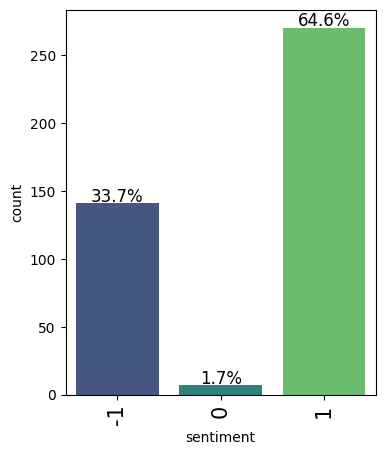

<Figure size 1000x500 with 0 Axes>

In [7]:
labeled_barplot(data, feature='sentiment', perc=True)

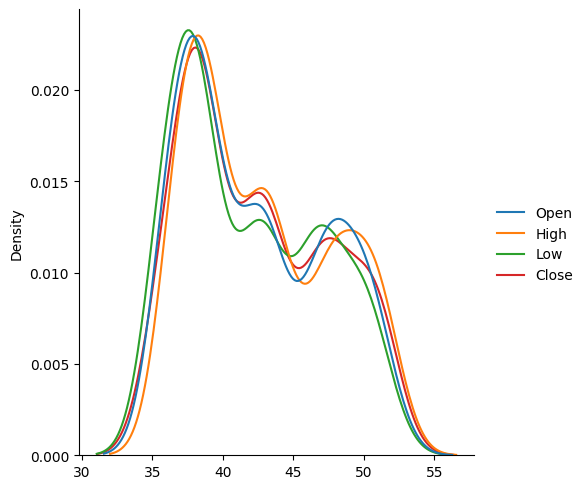

In [8]:
sns.displot(data=data[['Open','High','Low','Close']], kind='kde', palette="tab10");


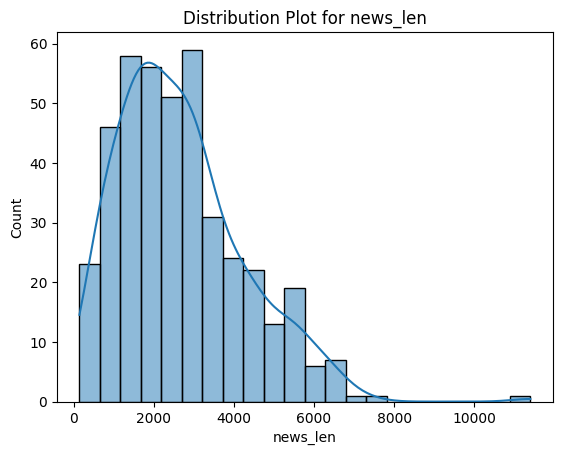

In [9]:
data['news_len'] = data['News'].apply(len)

distribution_hist(df=data, feature_numeric=f"news_len")


* Distribution of individual variables
* Compute and check the distribution of the length of news content



### **Bivariate Analysis**

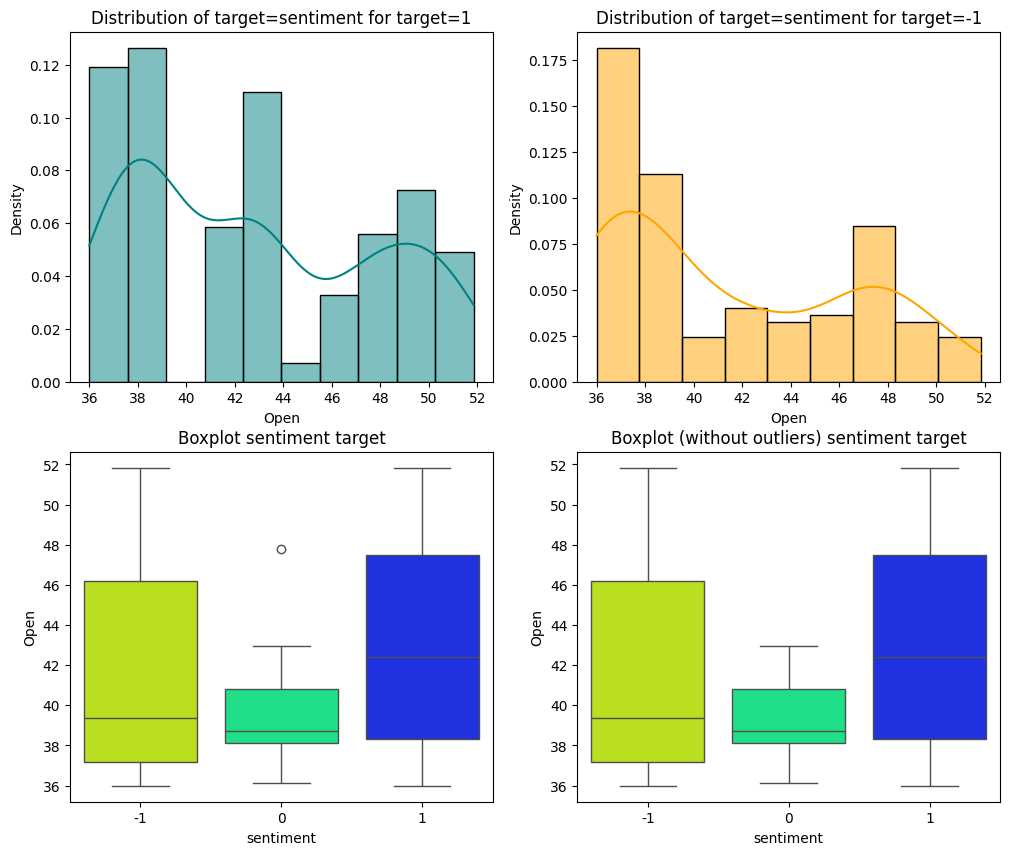

In [10]:
# Plot the distribution of Open price for each sentiment
distribution_plot_feature_target(data, predictor="Open", target="sentiment")

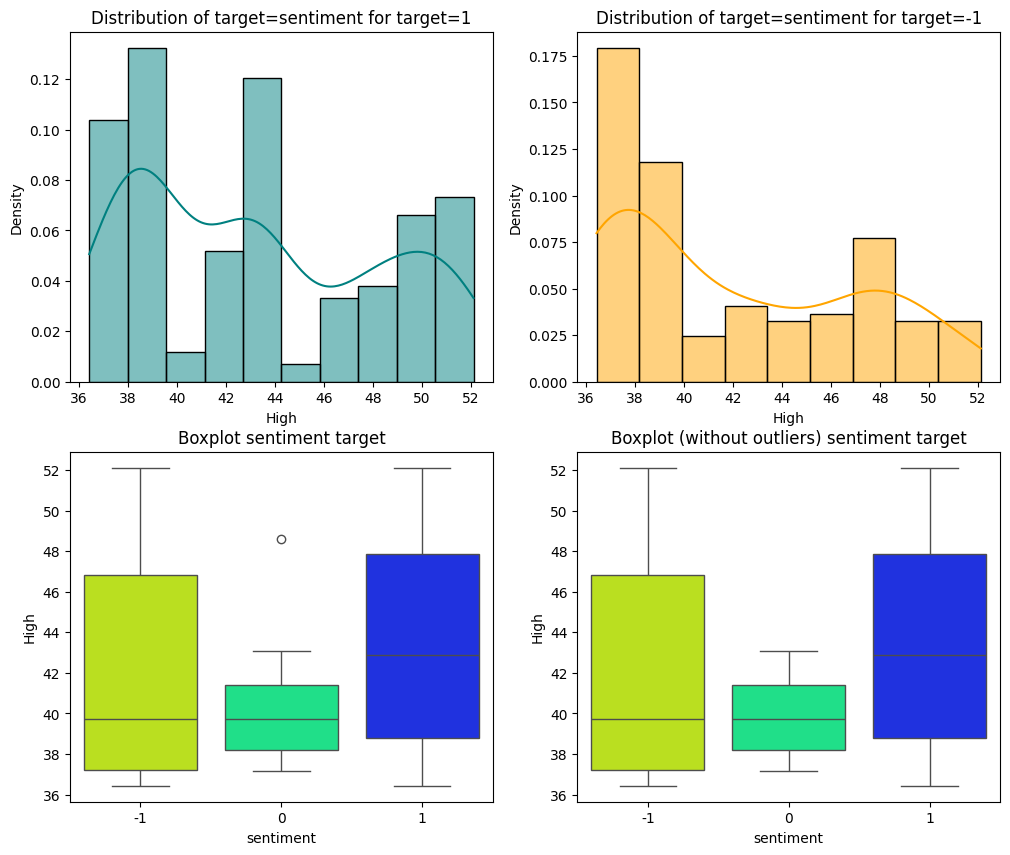

In [11]:
# Plot the distribution of High price for each sentiment
distribution_plot_feature_target(data, predictor="High", target="sentiment")

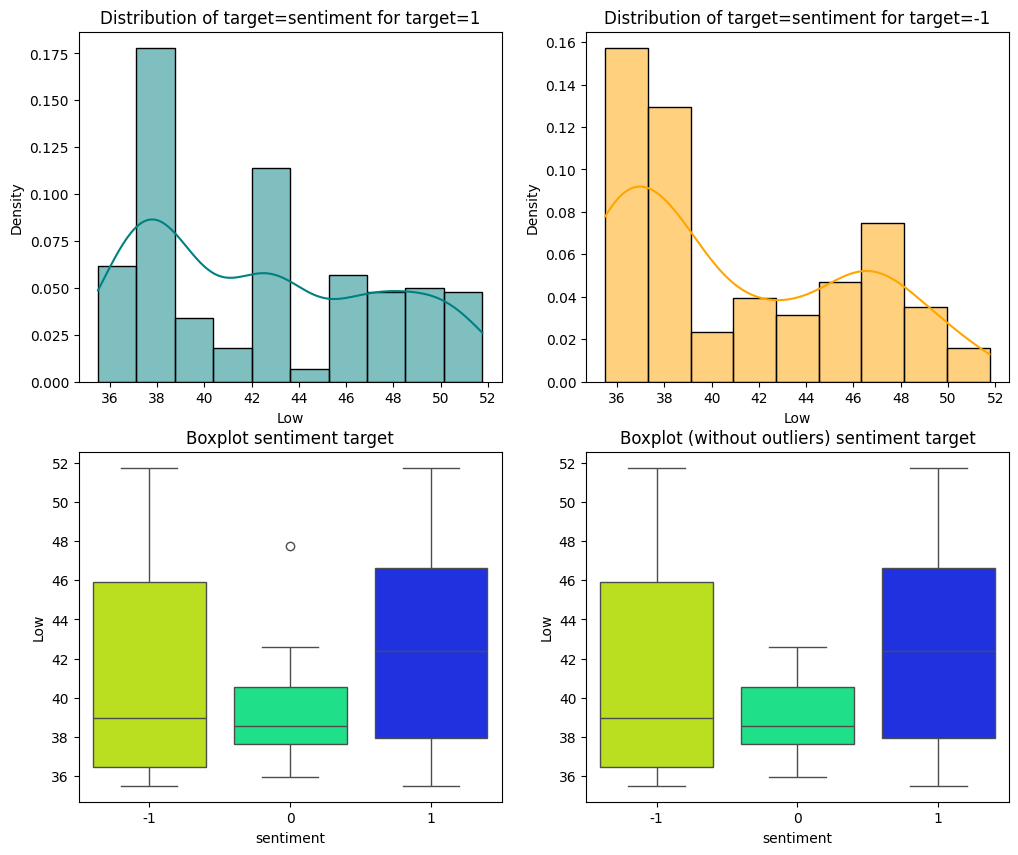

In [12]:
distribution_plot_feature_target(data, predictor="Low", target="sentiment")


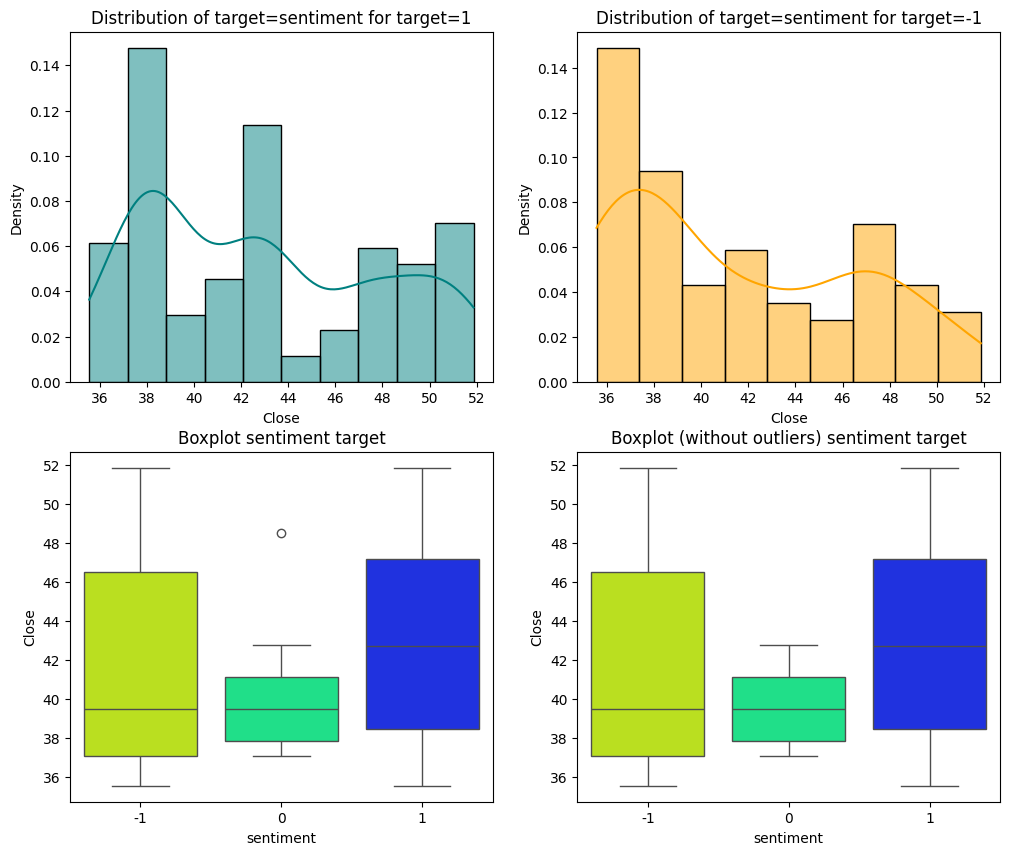

In [13]:
# Plot the distribution of Low price for each sentiment
distribution_plot_feature_target(data, predictor="Close", target="sentiment")

#### Date vs Price

<Axes: xlabel='Date', ylabel='Open'>

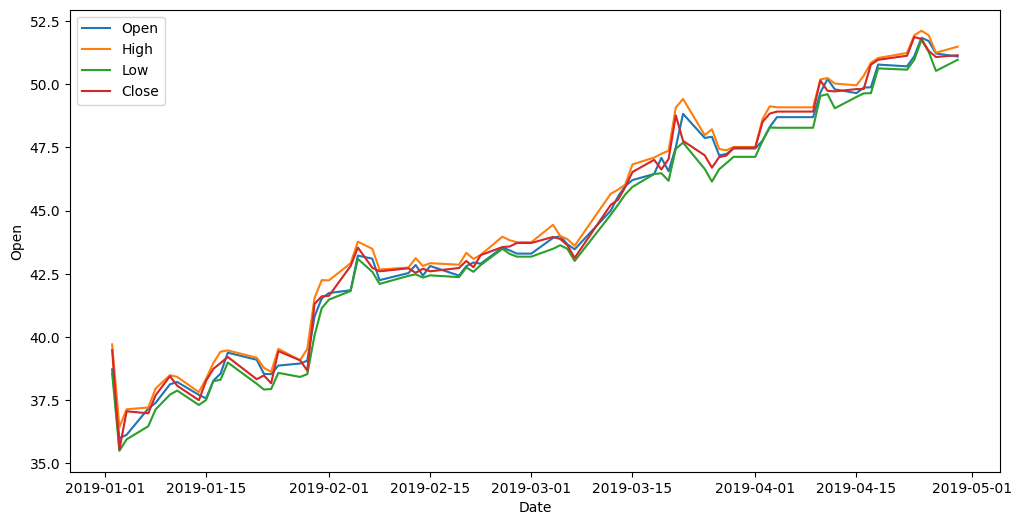

In [14]:
data['Date'] = pd.to_datetime(data['Date'])

# Sort by Date
data = data.sort_values(by="Date")

# Plot trends over the time
plt.figure(figsize=(12,6))
sns.lineplot(data=data, x='Date', y='Open', label='Open')
sns.lineplot(data=data, x='Date', y='High', label='High')
sns.lineplot(data=data, x='Date', y='Low', label='Low')
sns.lineplot(data=data, x='Date', y='Close', label='Close')


In [15]:
stock_daily = data.groupby('Date').agg(
    {
        'Open': 'mean',
        'High': 'mean',
        'Low': 'mean',
        'Close': 'mean',
        'Volume': 'mean',
    }
).reset_index()  # Group the 'stocks' DataFrame by the 'Date' column

stock_daily.set_index('Date', inplace=True)
stock_daily.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,38.72,39.71,38.56,39.48,130672400.0
2019-01-03,35.99,36.43,35.50,35.55,103544800.0
2019-01-04,36.13,37.14,35.95,37.06,111448000.0
2019-01-07,37.17,37.21,36.47,36.98,109012000.0
2019-01-08,37.39,37.96,37.13,37.69,216071600.0


#### Close vs Volume

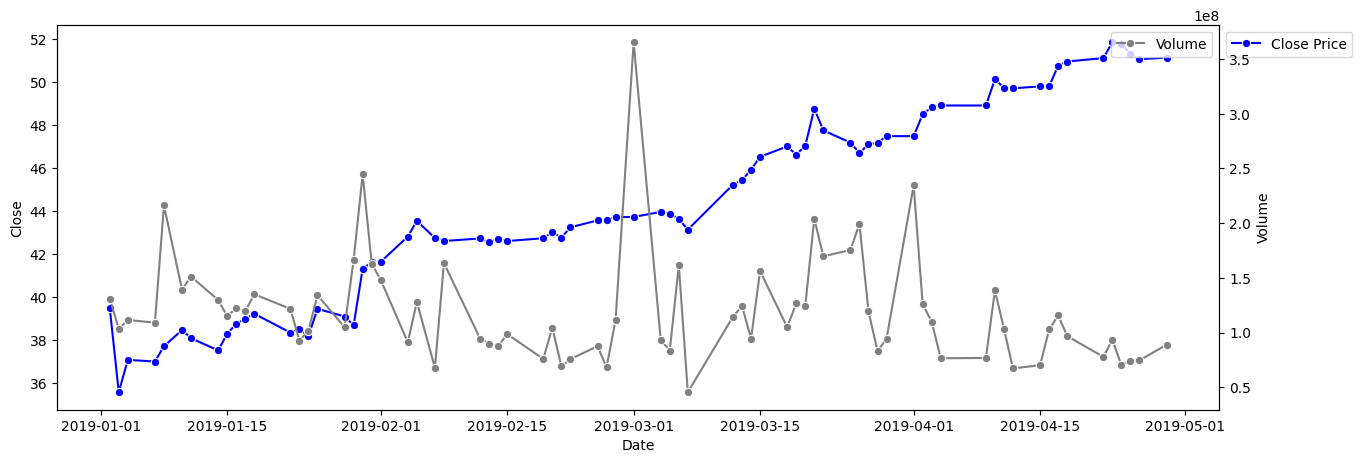

In [16]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15,5))

# Lineplot on primary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Close', ax=ax1, color='blue', marker='o', label='Close Price')

# Create a secondary y-axis
ax2 = ax1.twinx()

# Lineplot on secondary y-axis
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));

#### Open vs Volume

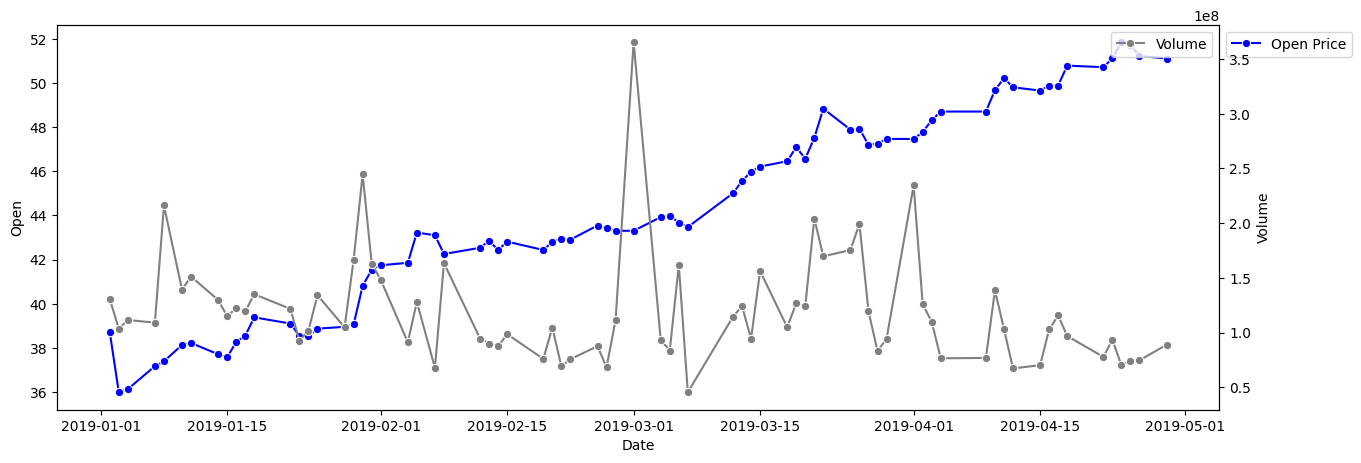

In [17]:
fig , ax1 = plt.subplots(figsize=(15,5))
sns.lineplot(data=stock_daily.reset_index(), x='Date', y='Open', ax=ax1, color='blue', marker='o', label='Open Price')

ax2 = ax1.twinx()

sns.lineplot(data=stock_daily.reset_index(), x= 'Date', y='Volume', ax=ax2, color='gray', marker='o', label='Volume')

ax1.legend(bbox_to_anchor=(1,1));



Observations from Price Trends Over Time:

- The stock prices ('Open', 'High', 'Low', and 'Close') show a general upward trend over the observed period, although there are fluctuations.
- The 'High' and 'Low' lines closely track the 'Open' and 'Close' lines, which is expected for daily price movements.
- The trading 'Volume' also shows variations over time, with some periods of higher and lower activity. There doesn't appear to be a strong visual correlation between volume spikes and significant price changes in this particular plot, but this would require further investigation.

#### Correlation Heatmap

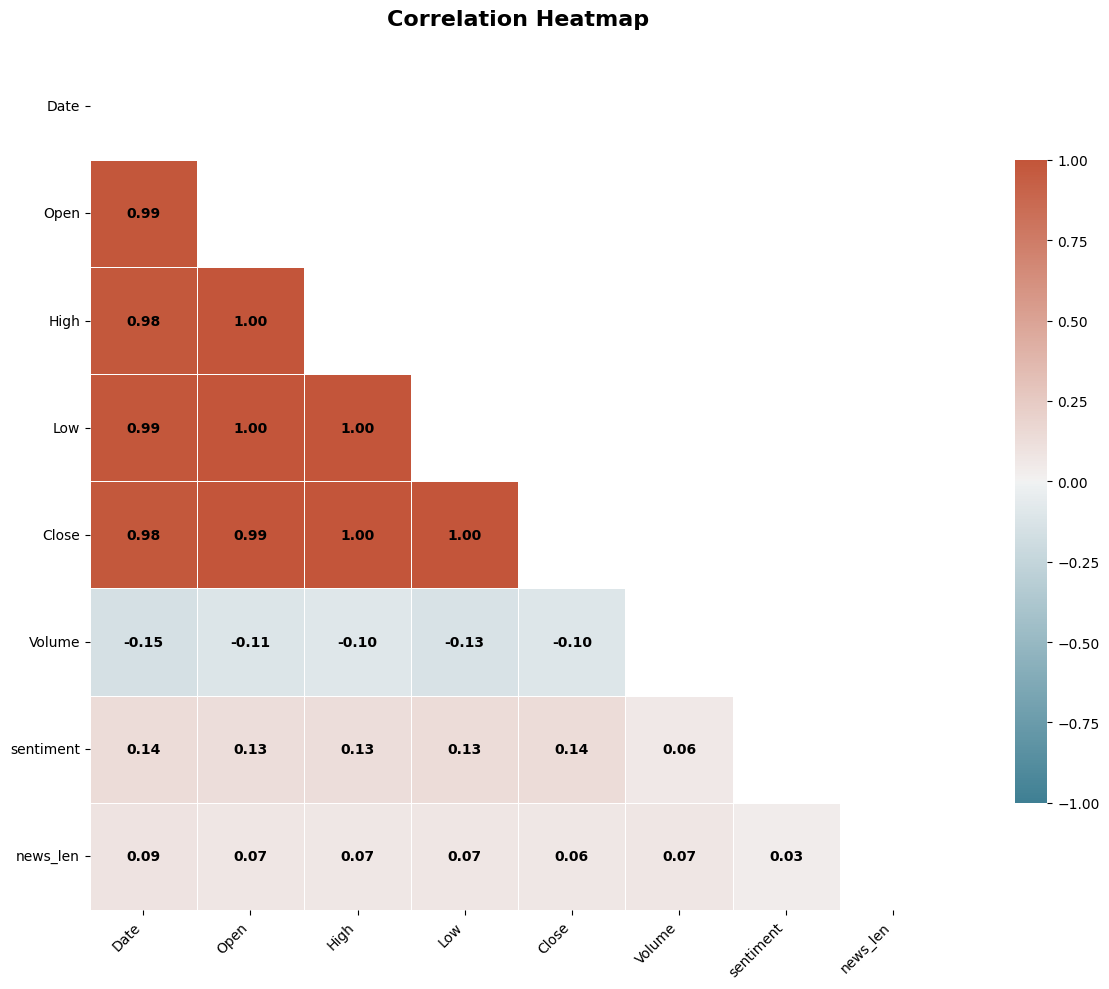

In [18]:
correlation_heatmap(df=data)

#### Observations from Correlation Heatmap:

* **Strong Positive Correlation:** There is a very strong positive correlation (close to 1) between the 'Open', 'High', 'Low', and 'Close' prices. This is expected as these values are all related to the daily stock price movement.
* **Volume Correlation:** The 'Volume' shows very weak correlation with the price features. This suggests that the number of shares traded does not have a strong linear relationship with the daily price changes in this dataset.
* **Sentiment Correlation:** The 'sentiment' label shows very weak correlation with all other numerical features. This indicates that there isn't a strong linear relationship between the assigned sentiment label and the stock's price movements or trading volume in this dataset. However, this does not necessarily mean there is no relationship at all, as the relationship might be non-linear or time-dependent.

## **Data Preprocessing**

In [19]:
data['Date'].describe()

count                              418
mean     2019-02-14 12:24:06.889952256
min                2019-01-02 00:00:00
25%                2019-01-11 00:00:00
50%                2019-01-31 00:00:00
75%                2019-03-21 00:00:00
max                2019-04-29 00:00:00
Name: Date, dtype: object

In [20]:
X_train = data[data['Date'] < '2019-03-21'].reset_index()
X_test = data[data['Date'] >= '2019-03-21'].reset_index()

import re

def clean_text(text):
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

data['News'] = data['News'].apply(clean_text)
display(data.head())

In [21]:
y_train = X_train['sentiment'].copy()
y_test = X_test['sentiment'].copy()


In [22]:
print("Train data shape",X_train.shape)
print("Test data shape ",X_test.shape)

print("Train label shape",y_train.shape)
print("Test label shape ",y_test.shape)


Train data shape (311, 10)
Test data shape  (107, 10)
Train label shape (311,)
Test label shape  (107,)


## **Word Embeddings**

#### **Word2Vec**
### **Generating Text Embeddings using Word2Vec**
#### ***Defining the model***


In [23]:
# Creating a list of words in the dataset
word_list = [item.split(' ') for item in data['News'].values]



In [24]:
vec_size = 300
# Instance of Word2Vec
model_W2V = Word2Vec(word_list, vector_size=vec_size, window=5, min_count=1, workers=4)

In [25]:
vocabulary = list(model_W2V.wv.key_to_index).__len__()
print(f"Vocabulary size is {vocabulary}")

Vocabulary size is 14577


#### Encoding the Dataset

In [26]:
words = list(model_W2V.wv.key_to_index.keys()) # Gettings the words in the word2vec model's vocabulary

word_vec_vocabulary = model_W2V.wv[words].tolist() # Gettings words vectors from the words in the model vocabulary

word_vect_dict = dict(zip(words, word_vec_vocabulary)) # dictionary with words and vectors

#### **Averaging the word vectors to get sentence encodings**


In [27]:
def average_vectorizer_Word2Vec(doc):
    # Initializing a feature vector for the sentence
    feature_vector = np.zeros((vec_size,), dtype="float64")

    # Creating a list of words in the sentence that are present in the model vocabulary
    words_in_vocab = [word for word in doc.split() if word in words]

    # adding the vector representations of the words
    for word in words_in_vocab:
        feature_vector += np.array(word_vect_dict[word])

    # Dividing by the number of words to get the average vector
    if len(words_in_vocab) != 0:
        feature_vector /= len(words_in_vocab)

    return feature_vector

In [28]:
start = time.time()
# Creating a dataframe of the vectirized documents

X_train_wv = pd.DataFrame(
    X_train['News'].apply(average_vectorizer_Word2Vec).tolist(),
    columns=['Features' +str(i) for i in range(vec_size)]
)

X_test_wv = pd.DataFrame(
    X_test['News'].apply(average_vectorizer_Word2Vec).tolist(),
    columns=['Features'+str(i) for i in range(vec_size)]
)

end = time.time()
print('Time taken', end-start)


Time taken 2.6407368183135986


In [29]:
print(f"Word and Vector training data shape: {X_train_wv.shape}")
print(f"Word and Vector test data shape: {X_test_wv.shape}")

Word and Vector training data shape: (311, 300)
Word and Vector test data shape: (107, 300)


### **Generating Text Embeddings using Sentence Transformer**
### **Sentence Transformer**


#### **Defining the model**


In [30]:
st_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

#### **Encoding the dataset**


In [31]:
# encoding the dataset
start = time.time()

X_train_st = st_model.encode(
    X_train['News'].values,
    show_progress_bar=True,
    device='cpu'

)
X_test_st = st_model.encode(
    X_test['News'].values,
    show_progress_bar=True,
    device='cpu'
)

end = time.time()
print("Time taken ",(end-start))

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Time taken  4.986854314804077


In [32]:
print(f"Training data shape Sentence Trasnformer: {X_train_st.shape}")
print(f"Test data shape Sentence Transformer: {X_test_st.shape}")

Training data shape Sentence Trasnformer: (311, 384)
Test data shape Sentence Transformer: (107, 384)


#### Observations:

* Each news content has been transform to a 384-dimentional vector in comparison with word2vec the 300 dimentional space

**Note:**  
You can use the helper functions provided below to:
- Plot a **confusion matrix** (`plot_confusion_matrix`)
- Generate key **classification metrics** like accuracy, recall, precision, and F1-score (`model_performance_classification_sklearn`)

These are ready-to-use. However, you’re welcome to explore and write your own evaluation code if you prefer. Feel free to modify or extend these as per your learning goals!

### **Build Random Forest Models using different text embeddings**

#### **Building a Random Forest Model using text embeddings obtained from the Word2Vec**

In [ ]:
# Instance of Random Model Classifier

with mlflow.start_run(run_name="Random Forest  Classifier (W2V)"):
    rf_word2vec = RandomForestClassifier(
        n_estimators=100,
        n_jobs=1,
        random_state=42,
        verbose=1,
        max_depth=10
    )

    #Fit the model on the training data
    rf_word2vec.fit(X_train_wv, y_train)
    #### Checking Training and Testing performance
    # Predicting on train data
    y_pred_train = rf_word2vec.predict(X_train_wv)
    # Predicting on test data
    y_pred_test = rf_word2vec.predict(X_test_wv)

    #Calculating different metrics on training data
    rf_train_wv = model_performance_classification_sklearn(y_train,y_pred_train)
    acc_train_wv = rf_train_wv['Accuracy'].values[0]
    recall_train_wv = rf_train_wv['Recall'].values[0]
    precision_train_wv = rf_train_wv['Precision'].values[0]
    f1_train_wv = rf_train_wv['F1'].values[0]

    #Calculating different metrics on test data
    rf_test_wv = model_performance_classification_sklearn(y_test, y_pred_test)
    acc_test_wv = rf_test_wv['Accuracy'].values[0]
    recall_test_wv = rf_test_wv['Recall'].values[0]
    precision_test_wv = rf_test_wv['Precision'].values[0]
    f1_test_wv = rf_test_wv['F1'].values[0]

    # Log metrics
    #Training
    mlflow.log_metric("accuracy training", acc_train_wv)
    mlflow.log_metric("recall training", recall_train_wv)
    mlflow.log_metric("precision training", precision_train_wv)
    mlflow.log_metric("f1 training", f1_train_wv)
    # Test
    mlflow.log_metric("accuracy testing", acc_test_wv)
    mlflow.log_metric("recall testing", recall_test_wv)
    mlflow.log_metric("precision testing", precision_test_wv)
    mlflow.log_metric("f1 testing", f1_test_wv)

    # Log Model
    mlflow.sklearn.log_model(rf_word2vec, 'Random Forest  Classifier (W2V)')

    #Calculating different metrics on training data
    #rf_train_wv = model_performance_classification_sklearn(y_train,y_pred_train)
    print("Training performance:\n", rf_train_wv)
    print("Test performance:\n",rf_test_wv)



##### Confusion Matrix

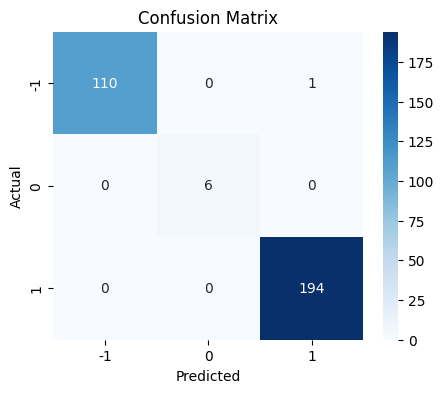

In [34]:
plot_confusion_matrix(y_train, y_pred_train)

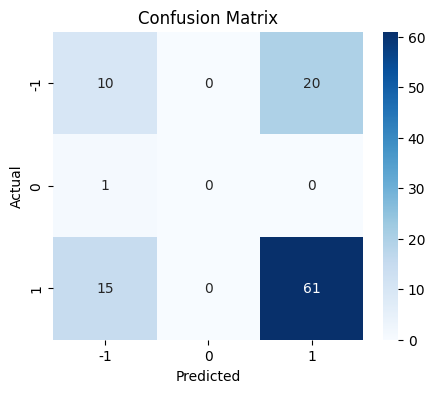

In [35]:
plot_confusion_matrix(y_test, y_pred_test)

#### **Building a Random Forest Model using text embeddings obtained from the Sentence Transformer**


In [ ]:
with mlflow.start_run(run_name="Random Forest  Classifier (Sentence Transformer)"):
    rf_st = RandomForestClassifier(n_estimators=100,
                                   n_jobs=1,
                                   random_state=42,
                                   verbose=1,
                                   max_depth=10
                                   )

    rf_st.fit(X_train_st, y_train)

    y_pred_train = rf_st.predict(X_train_st)
    y_pred_test = rf_st.predict(X_test_st)

    #### **Checking Training and Test Performance**
    # Compute metrics
    #Calculating different metrics on training data
    rf_train_st = model_performance_classification_sklearn(y_train,y_pred_train)
    acc_train_st = rf_train_st['Accuracy'].values[0]
    recall_train_st = rf_train_st['Recall'].values[0]
    precision_train_st = rf_train_st['Precision'].values[0]
    f1_train_st = rf_train_st['F1'].values[0]

    #Calculating different metrics on test data
    rf_test_st = model_performance_classification_sklearn(y_test, y_pred_test)
    acc_test_st = rf_test_st['Accuracy'].values[0]
    recall_test_st = rf_test_st['Recall'].values[0]
    precision_test_st = rf_test_st['Precision'].values[0]
    f1_test_st = rf_test_st['F1'].values[0]


    # Log Metrics
    mlflow.log_metric("accuracy training", acc_train_st)
    mlflow.log_metric("recall training", recall_train_st)
    mlflow.log_metric("precision training", precision_train_st)
    mlflow.log_metric("f1 training", f1_train_st)

    mlflow.log_metric("accuracy testing", acc_test_st)
    mlflow.log_metric("recall testing", recall_test_st)
    mlflow.log_metric("precision testing", precision_test_st)
    mlflow.log_metric("f1 testing", f1_test_st)
    mlflow.sklearn.log_model(rf_st, 'Random Forest  Classifier (Sentence Transformer)')


    print("Training performance:\n", rf_train_st)
    print("Test performance:\n",rf_test_st)





#### **Confusion Matrix**


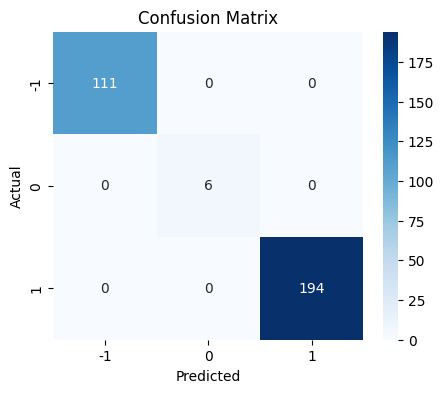

In [37]:
plot_confusion_matrix(y_train, y_pred_train)

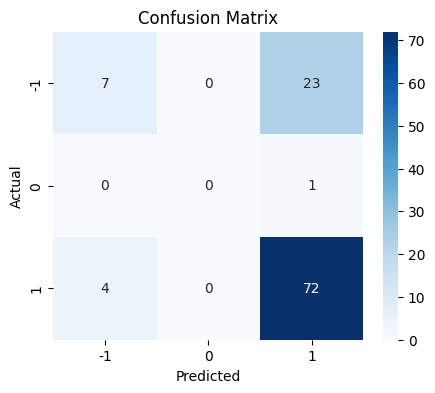

In [38]:
plot_confusion_matrix(y_test, y_pred_test)


### **Building Neural Network Models using different text embeddings**

#### **Building a Neural Network Model using text embeddings obtained from the Word2Vec**


In [39]:
label_mapping = {
    1:2,
    -1:0,
    0:1
}
# Transform label

y_train_mapped_wv = [label_mapping[label] for label in y_train]
y_test_mapped_wv = [label_mapping[label] for label in y_test]

# Convert feature Dataframe to a Numpy array

X_train_wv_np = np.array(X_train_wv)
X_test_wv_np = np.array(X_test_wv)
y_train_mapped_wv_np = np.array(y_train_mapped_wv)
y_test_mapped_wv_np = np.array(y_test_mapped_wv)



In [ ]:
# Clear previous TensorFlow /Keras from memory
tf.keras.backend.clear_session()
gc.collect()

with mlflow.start_run(run_name="Neural Network Classifier (W2V)"):
    # Define Model Architecture
    nnc_w2v = Sequential()
    # Input Layer
    nnc_w2v.add(Dense(vec_size, activation="relu", input_shape=(X_train_wv.shape[1],)))

    # Dropout Layer
    nnc_w2v.add(Dropout(0.5))

    # 1stHidden Layer
    nnc_w2v.add(Dense(64, activation="relu"))


    #2nd Hidden Layer
    nnc_w2v.add(Dense(128, activation="relu"))

    # Dropout Layer
    nnc_w2v.add(Dropout(0.5))

    ## output layer

    nnc_w2v.add(Dense(3, activation="softmax"))

    #Compile Layer

    nnc_w2v.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    # Summary


    history = nnc_w2v.fit(
        X_train_wv_np,y_train_mapped_wv_np,
        validation_data=(X_test_wv_np,y_test_mapped_wv_np),
        epochs=100,
        batch_size=32,
    )

    # Predict class probabilities on training data

    y_train_pred_probs = nnc_w2v.predict(X_train_wv_np)
    # Transform probabilities to class labels
    y_train_preds = tf.argmax(y_train_pred_probs, axis =1).numpy()

    # Predict probabilities on test data

    y_test_pred_probs = nnc_w2v.predict(X_test_wv_np)
    y_test_preds = tf.argmax(y_test_pred_probs, axis =1).numpy()

    # Convert back to [-1,-0-1]
    label_mapping = {
        2:1,
        0:-1,
        1:0
    }

    y_train_preds = np.array([label_mapping[label] for label in y_train_preds])
    y_test_preds = np.array([label_mapping[label] for label in y_test_preds])


    #C alculating different metrics on training data
    NN_train_wv = model_performance_classification_sklearn(y_train,y_train_preds)
    acc_train_wv = NN_train_wv['Accuracy'].values[0]
    recall_train_wv = NN_train_wv['Recall'].values[0]
    precision_train_wv = NN_train_wv['Precision'].values[0]
    f1_train_wv = NN_train_wv['F1'].values[0]

    # Calculation metrics for test data

    NN_test_wv = model_performance_classification_sklearn(y_test, y_test_preds)
    acc_test_wv = NN_test_wv['Accuracy'].values[0]
    recall_test_wv = NN_test_wv['Recall'].values[0]
    precision_test_wv = NN_test_wv['Precision'].values[0]
    f1_test_wv = NN_test_wv['F1'].values[0]

    # Log Metrics

    mlflow.log_metric("accuracy training", acc_train_wv)
    mlflow.log_metric("recall training", recall_train_wv)
    mlflow.log_metric("precision training", precision_train_wv)
    mlflow.log_metric("f1 training", f1_train_wv)

    mlflow.log_metric("accuracy testing", acc_test_wv)
    mlflow.log_metric("recall testing", recall_test_wv)
    mlflow.log_metric("precision testing", precision_test_wv)
    mlflow.log_metric("f1 testing", f1_test_wv)

    mlflow.sklearn.log_model(nnc_w2v, 'Neural Network Classifier (W2V)')

    print(f"{nnc_w2v.summary()}")
    print("Training performance:\n", NN_train_wv)
    print("Testing performance:\n", NN_test_wv)







**Confusion Matrix Training**

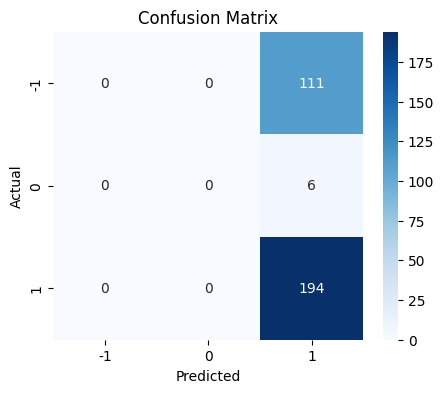

In [41]:
plot_confusion_matrix(y_train, y_train_preds)

**Confusion Matrix Testing**

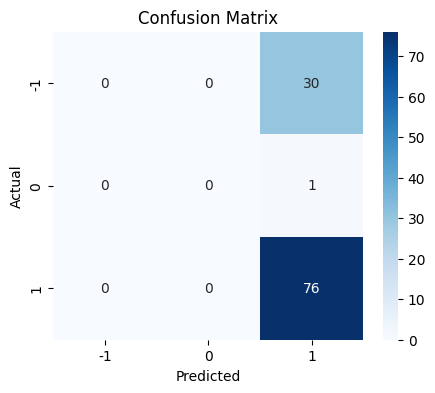

In [42]:
plot_confusion_matrix(actual=y_test, predicted=y_test_preds)

#### **Building a Neural Network Model using text embeddings obtained from the Sentence Transformer**


In [43]:
# Convert the labels
label_mapping = {1:2, -1:0, 0:1}

y_train_mapped_st = [label_mapping[label] for label in y_train]
y_test_mapped_st = [label_mapping[label] for label in y_test]

# Convert features Datarame to a numpay array

X_train_st_np = np.array(X_train_st)
X_test_st_np = np.array(X_test_st)

y_train_mapped_st_np = np.array(y_train_mapped_st)
y_test_mapped_st_np = np.array(y_test_mapped_st)



In [ ]:
tf.keras.backend.clear_session()
gc.collect()

with mlflow.start_run(run_name="Neural Network Classifier (Sentence Transformers)"):
    # Define the architecture
    nnc_st = Sequential()
    # Input Layer
    nnc_st.add(Dense(vec_size, activation="relu", input_shape=(X_train_st.shape[1],)))
    # Regularization
    nnc_st.add(Dropout(0.5))
    # 1st hidden layer
    nnc_st.add(Dense(64, activation="relu"))
    # Regularization
    nnc_st.add(Dropout(0.5))
    # 2nd layer
    nnc_st.add(Dense(128, activation="relu"))
    # Output Layer
    nnc_st.add(Dense(3, activation="softmax"))

    # Compile the model

    nnc_st.compile(optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    history = nnc_st.fit(
        X_train_st_np,y_train_mapped_st_np,
        validation_data=(X_test_st_np,y_test_mapped_st_np),
        epochs=100,
        batch_size=32,

    )
    # Predicts class probabilities
    # Predict probabilities using training data
    y_train_pred_probs = nnc_st.predict(X_train_st_np)
    # Convert training probabilities to class labes
    y_train_preds = tf.argmax(y_train_pred_probs, axis =1).numpy()
    # Predict Probabilities using test data
    y_test_pred_probs = nnc_st.predict(X_test_st_np)
    # Conver Testing probabilities to class labes
    y_test_preds = tf.argmax(y_test_pred_probs, axis =1).numpy()


    # Get back the mapping [-1,1, 0]
    label_mapping = {2:1, 0:-1, 1:0}

    y_train_preds = np.array([label_mapping[label] for label in y_train_preds])
    y_test_preds = np.array([label_mapping[label] for label in y_test_preds])

    #Calculating different metrics on training data
    NN_train_st = model_performance_classification_sklearn(y_train,y_train_preds)
    acc_train_st = NN_train_st['Accuracy'].values[0]
    recall_train_st = NN_train_st['Recall'].values[0]
    precision_train_st = NN_train_st['Precision'].values[0]
    f1_train_st = NN_train_st['F1'].values[0]

    # Calculating different metrics on testing data
    #Calculating different metrics on test data
    NN_test_st = model_performance_classification_sklearn(y_test,y_test_preds)
    acc_test_st = NN_test_st['Accuracy'].values[0]
    recall_test_st = NN_test_st['Recall'].values[0]
    precision_test_st = NN_test_st['Precision'].values[0]
    f1_test_st = NN_test_st['F1'].values[0]




    # Mlflow logging
    mlflow.log_metric("accuracy training", acc_train_st)
    mlflow.log_metric("recall training", recall_train_st)
    mlflow.log_metric("precision training", precision_train_st)
    mlflow.log_metric("f1 training", f1_train_st)

    mlflow.log_metric("accuracy testing", acc_test_st)
    mlflow.log_metric("recall testing", recall_test_st)
    mlflow.log_metric("precision testing", precision_test_st)
    mlflow.log_metric("f1 testing", f1_test_st)

    mlflow.sklearn.log_model(nnc_st, 'Neural Network Classifier (Sentence Transformers)')

    nnc_st.summary()
    print("Training performance:\n", NN_train_st)
    print("Test performance:\n",NN_test_st)

### **Building a Suport Vector Machine Classifier Model using text embeddings obtained from the Sentence Transformer**

In [ ]:


from sklearn.svm import SVC

with mlflow.start_run(run_name="Support Vector Machine Classifier (Sentence Transformer)"):
    # Define the SVM model
    svm_st = SVC(kernel='linear', C=100, gamma='scale',random_state=42)

    # Train the model
    svm_st.fit(X_train_st, y_train)

    # Predict on training and test data
    y_pred_train_svm_st = svm_st.predict(X_train_st)
    y_pred_test_svm_st = svm_st.predict(X_test_st)

    # Evaluate model performance
    svm_train_st = model_performance_classification_sklearn(y_train, y_pred_train_svm_st)
    svm_test_st = model_performance_classification_sklearn(y_test, y_pred_test_svm_st)

    # Log metrics
    mlflow.log_metric("accuracy training", svm_train_st['Accuracy'].values[0])
    mlflow.log_metric("recall training", svm_train_st['Recall'].values[0])
    mlflow.log_metric("precision training", svm_train_st['Precision'].values[0])
    mlflow.log_metric("f1 training", svm_train_st['F1'].values[0])

    mlflow.log_metric("accuracy testing", svm_test_st['Accuracy'].values[0])
    mlflow.log_metric("recall testing", svm_test_st['Recall'].values[0])
    mlflow.log_metric("precision testing", svm_test_st['Precision'].values[0])
    mlflow.log_metric("f1 testing", svm_test_st['F1'].values[0])

    # Log model
    mlflow.sklearn.log_model(svm_st, 'Support Vector Machine Classifier (Sentence Transformer)r')


    print("SVM Training Performance (Sentence Transformer):\n", svm_train_st)
    print("SVM Test Performance (Sentence Transformer):\n", svm_test_st)



SVM Training Confusion Matrix (Sentence Transformer):


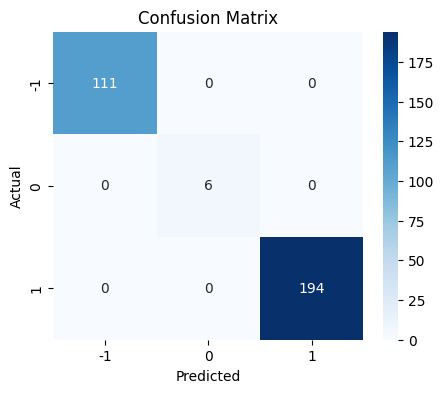

SVM Test Confusion Matrix (Sentence Transformer):


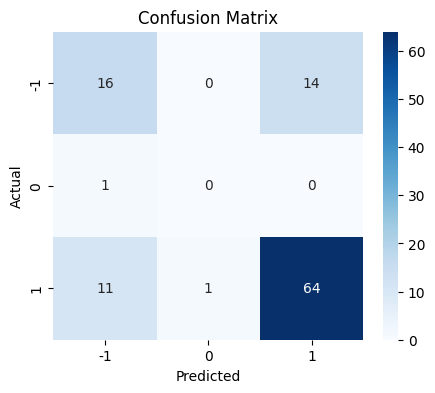

In [46]:
# Plot confusion matrix
print("SVM Training Confusion Matrix (Sentence Transformer):")
plot_confusion_matrix(y_train, y_pred_train_svm_st)

print("SVM Test Confusion Matrix (Sentence Transformer):")
plot_confusion_matrix(y_test, y_pred_test_svm_st)

### **Building a SXGBoost Model Classifier using text embeddings obtained from the Sentence Transformer**

#### **Implement GRIDSEARCH to find the best parameters for the XGBoost model

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42)

# Map the labels to 0, 1, 2
label_mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = y_train.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_st, y_train_mapped)

# Print best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_xgb_model_st = grid_search.best_estimator_
y_pred_test_xgb = best_xgb_model_st.predict(X_test_st)

# Map the predicted labels back to the original format
reverse_label_mapping = {0: -1, 1: 0, 2: 1}
y_pred_test_xgb = np.array([reverse_label_mapping[label] for label in y_pred_test_xgb])


# Calculate and print test performance metrics
xgb_test_perf = model_performance_classification_sklearn(y_test, y_pred_test_xgb)
print("XGBoost Test Performance:\n", xgb_test_perf)

# Log best model and metrics with MLflow
with mlflow.start_run(run_name="XGBoost_GridSearch_Best_Model"):
    mlflow.log_params(grid_search.best_params_)
    mlflow.log_metric("accuracy testing", xgb_test_perf['Accuracy'].values[0])
    mlflow.log_metric("recall testing", xgb_test_perf['Recall'].values[0])
    mlflow.log_metric("precision testing", xgb_test_perf['Precision'].values[0])
    mlflow.log_metric("f1 testing", xgb_test_perf['F1'].values[0])
    mlflow.sklearn.log_model(best_xgb_model_st, 'best_xgboost_model_st')




XGBoost Test Confusion Matrix:


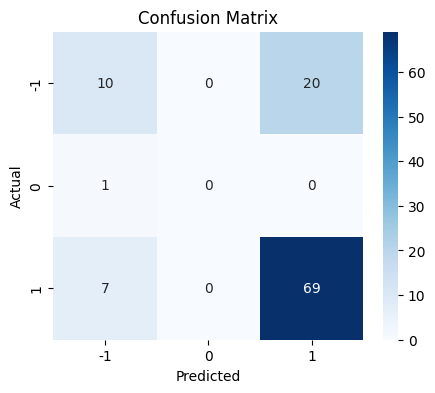

In [49]:
# Plot confusion matrix
print("XGBoost Test Confusion Matrix:")
plot_confusion_matrix(y_test, y_pred_test_xgb)

In [52]:
!mlflow ui

INFO:     127.0.0.1:52928 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:52946 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:52957 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:52958 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:52975 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
INFO:     127.0.0.1:52984 - "POST /ajax-api/2.0/mlflow/runs/search HTTP/1.1" 200 OK
^C
INFO:     Shutting down
INFO:     Shutting down
INFO:     Shutting down
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [5061]
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [5060]
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [5059]
INFO:     Waiting f

### **Model Performance Summary and Final Model Selection**

In [51]:
svm_test_st

,Accuracy,Recall,Precision,F1
0,0.747664,0.747664,0.743008,0.745052


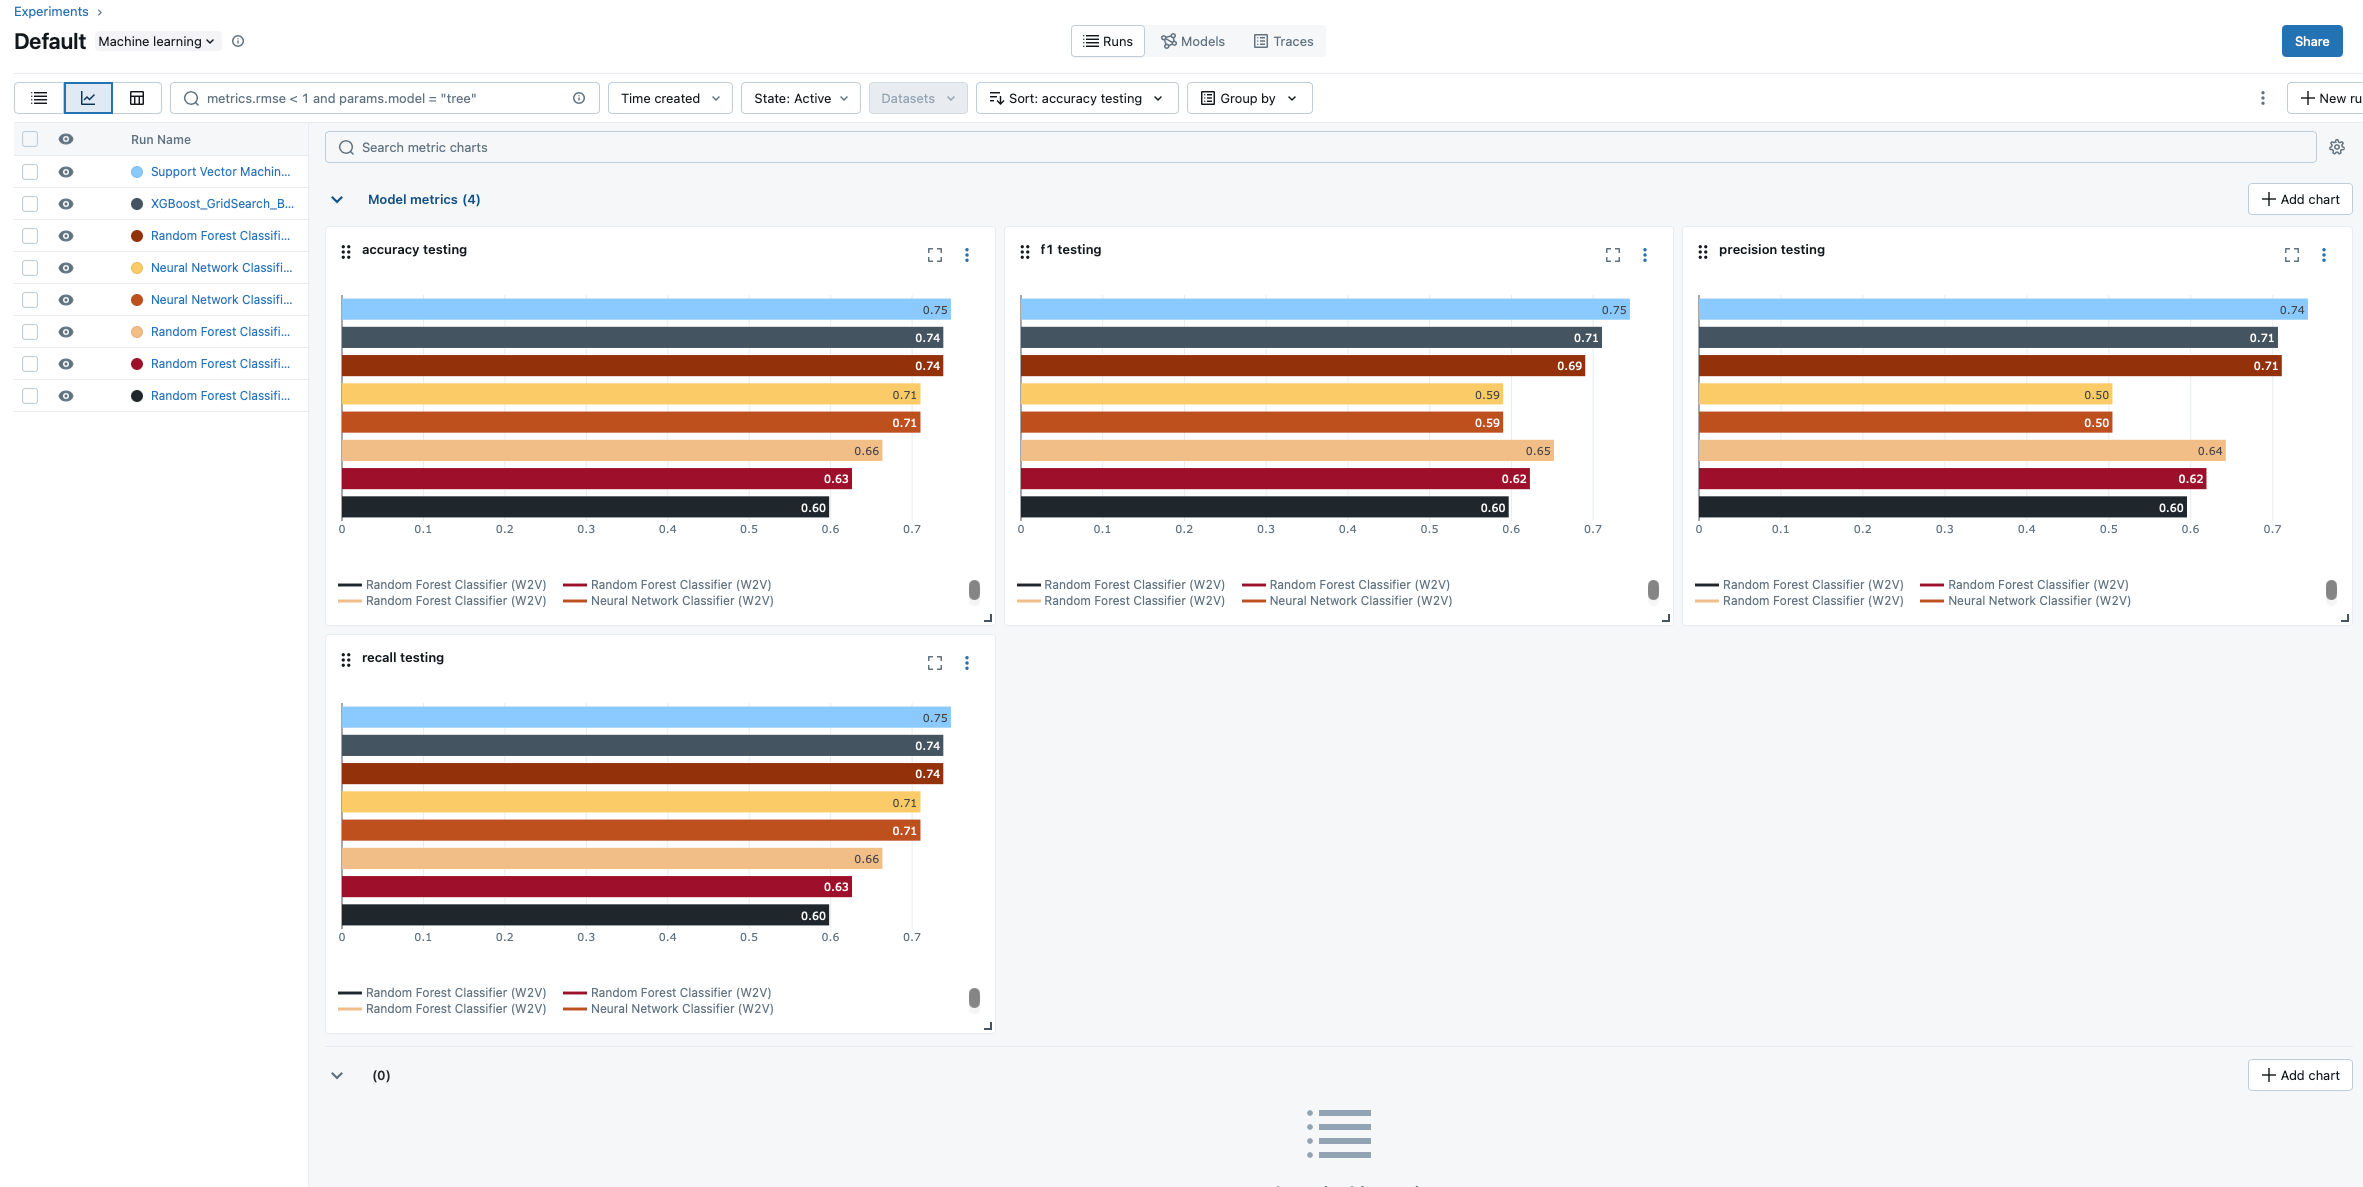

## **Conclusions and Recommendations**

**Based on the model performance comparison on the test data:**

# Final Model Performance

* Support Vector Machine Classifier has the best performance among all metrics **accuracy:0.747664 Recall: 0.747664, Precision: 0.743008 and F1: 0.745052**, followed by XGBoost prototyped using GridSearch and Random Forest Classifier with  0.74 both
* The Neural Network models, regardless of the embedding type used (Word2Vec or Sentence Transformer), had the same accuracy of approximately 0.710 on the test set.
* The Random Forest model with Word2Vec embeddings performed the worst among all models, with an accuracy of approximately 0.598.
* Sentence Transformer captured the best meaning in this dataset

* Recommendations:

 - The SVM model with Sentence Transformer embeddings appears to be the best performing model based on test accuracy. It would be a strong candidate for deployment in the AI-driven sentiment analysis system.
- Further investigation into the neural network models could involve exploring different architectures, activation functions, optimizers, and training epochs to potentially improve their performance.
- While XGBoost showed good performance, the Sentence Transformer embeddings seem to provide better results compared to Word2Vec embeddings for this specific task and dataset, regardless of the model used.

* To further enhance the system, consider:

- Collecting more data: A larger and more diverse dataset could improve model generalization.
- Exploring other pre-trained language models: Other Sentence Transformer models or large language models might capture sentiment more effectively.
- Incorporating financial specific vocabulary or fine-tuning on financial news: This could help the model better understand the nuances of sentiment in financial contexts.
- Analyzing the impact of sentiment on stock price movement: Beyond classification accuracy, understanding the correlation and potential predictive power of the sentiment scores on actual stock price changes would be valuable for the investment firm.
- I have built and compared several classification models for sentiment analysis using different text embeddings.

<font size=6 color='blue'>Power Ahead</font>
___